In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3,4,5,6,7" #Cuda01
os.environ["CUDA_VISIBLE_DEVICES"]="0" #Cuda02

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.nn import Parameter
import os 
import sys
#sys.path.append('../')

import probtorch
from probtorch.util import expand_inputs

# Empty cuda cache 
torch.cuda.empty_cache()

# Specify cuda device 
#torch.set_default_device(torch.device('cuda:1'))

print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available(),
      'current device: ', torch.cuda.current_device())
torch.cuda.device_count()

probtorch: 0.0+4355347 torch: 1.12.1 cuda: True current device:  0


1

# Parameters

In [2]:
# model parameters
NUM_HIDDEN = 1024
CLASS_TYPE= 'CN_MCI_AD'
if CLASS_TYPE=='CN_AD': 
    NUM_AD_GROUP = 2
elif CLASS_TYPE=='CN_MCI_AD':
    NUM_AD_GROUP = 3
elif CLASS_TYPE=='EMCI_LMCI':
    NUM_AD_GROUP = 4
NUM_SEX = 2
NUM_AGE = 8
NUM_CONT = 100
LEAKY_ALPHA = 0.02

# fixed training parameters
NUM_SAMPLES = None # num of samples S to estimate ELBO
BETA1 = 0.90
TEMPERATURE = 0.66
EPS = 1e-9
CUDA = torch.cuda.is_available()
#CUDA = True

# path parameters
MODEL_NAME = 'ADNI2D' 
DATA_PATH = '../data'
WEIGHTS_PATH = '../examples/weights/ADNI'
RESTORE = False

# Encoder Model

In [7]:
# Conv encoder, architecture adapted from Joint VAE (https://github.com/Schlumberger/joint-vae/blob/master/jointvae/models.py from line 56)
class Encoder(nn.Module):
    def __init__(self, num_hidden=NUM_HIDDEN,
                       num_AD_group=NUM_AD_GROUP, 
                       num_sex=NUM_SEX,
                       num_age=NUM_AGE,
                       num_cont=NUM_CONT,
                       temperature=TEMPERATURE):
        super(self.__class__, self).__init__()
        self.img_to_features = nn.Sequential(
                            nn.Conv2d(in_channels=1, 
                                      out_channels=32, 
                                      kernel_size=3, 
                                      stride=1, 
                                      padding=1),
                            nn.LeakyReLU(LEAKY_ALPHA),
                            nn.Conv2d(in_channels=32, 
                                      out_channels=32, 
                                      kernel_size=3, 
                                      stride=1, 
                                      padding=1),
                            nn.LeakyReLU(LEAKY_ALPHA),
                            nn.MaxPool2d(kernel_size=2), # 91x109
                            nn.Conv2d(in_channels=32, 
                                      out_channels=64, 
                                      kernel_size=3, 
                                      stride=1, 
                                      padding=1),
                            nn.LeakyReLU(LEAKY_ALPHA),
                            nn.Conv2d(in_channels=64, 
                                      out_channels=64, 
                                      kernel_size=4, 
                                      stride=1, 
                                      padding=1),        
                            nn.LeakyReLU(LEAKY_ALPHA),   # 90x108
                            nn.MaxPool2d(kernel_size=3), # 30x36
                            nn.Conv2d(in_channels=64, 
                                      out_channels=64, 
                                      kernel_size=3, 
                                      stride=1, 
                                      padding=1),
                            nn.LeakyReLU(LEAKY_ALPHA),
                            nn.Conv2d(in_channels=64, 
                                      out_channels=64, 
                                      kernel_size=3, 
                                      stride=1, 
                                      padding=1),
                            nn.LeakyReLU(LEAKY_ALPHA),
                            nn.MaxPool2d(kernel_size=2))
        self.features_to_hidden = nn.Sequential(
                                    nn.Linear(64 * 15 * 18, num_hidden),
                                    nn.LeakyReLU(LEAKY_ALPHA))
        self.log_weights_AD = nn.Linear(num_hidden + num_age, num_AD_group)
        self.log_weights_sex = nn.Linear(num_hidden, num_sex)
        self.log_weights_age = nn.Linear(num_hidden, num_age)
        self.digit_temp = torch.tensor(temperature)
        self.cont_mean = nn.Linear(num_hidden + num_AD_group + num_age + num_sex, num_cont)
        self.cont_log_std = nn.Linear(num_hidden + num_AD_group + num_age + num_sex, num_cont)
     
    def forward(self, images, labels_AD=None, labels_sex=None, labels_age=None, num_samples=None):
        q = probtorch.Trace()
        
        # Pass image through convolution
        features = self.img_to_features(images)
        
        # Flatten features
        features = torch.flatten(features, 1)

        hiddens = self.features_to_hidden(features)
        
        sex = q.concrete(logits=self.log_weights_sex(hiddens),
                              temperature=self.digit_temp,
                              value=labels_sex,
                              name='sex')
        age = q.concrete(logits=self.log_weights_age(hiddens),
                              temperature=self.digit_temp,
                              value=labels_age,
                              name='age')
        
        hiddens_AD = torch.cat([age, hiddens], -1)
        AD_group = q.concrete(logits=self.log_weights_AD(hiddens_AD),
                              temperature=self.digit_temp,
                              value=labels_AD,
                              name='AD_group')
        
        hiddens_cont = torch.cat([AD_group, age, sex, hiddens], -1)
        cont_mean = self.cont_mean(hiddens_cont)
        cont_std = torch.exp(self.cont_log_std(hiddens_cont))
        q.normal(cont_mean,
                 cont_std,
                 name='cont')
        return q

# Decoder Model

In [8]:
# Conv decoder, architecture adapted from Joint VAE (https://github.com/Schlumberger/joint-vae/blob/master/jointvae/models.py from line 108)
def scaled_sigmoid(input):
    return 1*torch.sigmoid(input)
  
class Scaled_sigmoid(nn.Module):
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__() # init the base class

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return scaled_sigmoid(input) # simply apply already implemented SiLU
    
    
class Decoder(nn.Module):
    def __init__(self, num_hidden=NUM_HIDDEN,
                       num_AD_group=NUM_AD_GROUP, 
                       num_sex=NUM_SEX,
                       num_age=NUM_AGE,
                       num_cont=NUM_CONT,
                       temperature=TEMPERATURE):
        super(self.__class__, self).__init__()
        self.num_AD_group = num_AD_group
        self.reshape = (64, 15, 18)
        self.log_weights_AD = torch.zeros(num_AD_group)
        self.log_weights_sex = torch.zeros(num_sex)
        self.log_weights_age = torch.zeros(num_age)
        self.digit_temp = torch.tensor(temperature)
        self.cont_mean = torch.zeros(num_cont)
        self.cont_std = torch.ones(num_cont)
        self.latent_to_features =  nn.Sequential(
                                      nn.Linear(num_cont + num_AD_group + num_sex + num_age, num_hidden),
                                      nn.LeakyReLU(LEAKY_ALPHA),
                                      nn.Linear(num_hidden, 64 * 15 * 18),
                                      nn.LeakyReLU(LEAKY_ALPHA))
        self.features_to_image = nn.Sequential(
                            nn.ConvTranspose2d(in_channels=64, 
                                      out_channels=64, 
                                      kernel_size=3, 
                                      stride=1, 
                                      padding=1),
                            nn.LeakyReLU(LEAKY_ALPHA),
                            nn.ConvTranspose2d(in_channels=64, 
                                      out_channels=64, 
                                      kernel_size=3, 
                                      stride=1, 
                                      padding=1),
                            nn.LeakyReLU(LEAKY_ALPHA),
                            nn.Upsample(scale_factor=(3,3)),
                            nn.ConvTranspose2d(in_channels=64, 
                                      out_channels=32, 
                                      kernel_size=3, 
                                      stride=1, 
                                      padding=1),
                            nn.LeakyReLU(LEAKY_ALPHA),
                            nn.ConvTranspose2d(in_channels=32, 
                                      out_channels=32, 
                                      kernel_size=3, 
                                      stride=1, 
                                      padding=1),
                            nn.LeakyReLU(LEAKY_ALPHA),
                            nn.Upsample(scale_factor=(2,2)),
                            nn.ConvTranspose2d(in_channels=32, 
                                      out_channels=32, 
                                      kernel_size=4, 
                                      stride=1, 
                                      padding=1),
                            nn.LeakyReLU(LEAKY_ALPHA),
                            nn.ConvTranspose2d(in_channels=32, 
                                      out_channels=1, 
                                      kernel_size=3, 
                                      stride=1, 
                                      padding=1),
                            nn.Sigmoid(),
                            nn.Upsample(scale_factor=(2,2)))

    def forward(self, images, q=None, num_samples=None, N=0, print_reconstruction=False):
        p = probtorch.Trace()
        AD_group = p.concrete(logits=self.log_weights_AD,
                              temperature=self.digit_temp,
                              value=q['AD_group'],
                              name='AD_group')
        sex = p.concrete(logits=self.log_weights_sex,
                         temperature=self.digit_temp,
                         value=q['sex'],
                         name='sex')
        age = p.concrete(logits=self.log_weights_age,
                         temperature=self.digit_temp,
                         value=q['age'],
                         name='age')

        cont = p.normal(self.cont_mean, 
                        self.cont_std,
                        value=q['cont'],
                        name='cont')
        
        # Pass latent variabels (20 style + 3 shape type) to features
        features = self.latent_to_features(torch.cat([AD_group, sex, age, cont], -1))
        
        # Features to images 
        images_mean = self.features_to_image(features.view(-1, *self.reshape))
        
        p.loss(lambda x_hat, x: -(torch.log(x_hat + EPS) * x + 
                                  torch.log(1 - x_hat + EPS) * (1-x)).sum(-1),
              images_mean, images, name='images')
        img = images_mean[0].cpu().detach().numpy()
        img = img.squeeze()
        
        if print_reconstruction:
            plt.imshow(img, cmap="gray")
            path = f'./Results/pictures/{TYPE_ARCHITECTURE}/lr_{LEARNING_RATE}/'
            if not os.path.isdir(path):
                os.makedirs(path)
            plt.savefig(os.path.join(path, f'recon_{NUM_EPOCHS}_lr{LEARNING_RATE}_style{NUM_STYLE}_beta{beta}_num_sample{NUM_SAMPLES}_{N}.png'))
    
        return p

# Loss

In [9]:
def elbo(q, p, beta=1.0, alpha=0.1):
    if NUM_SAMPLES is None:
        return probtorch.objectives.montecarlo.elbo(q, p, sample_dim=None, batch_dim=0, beta=beta, alpha=alpha)
    else:
        return probtorch.objectives.montecarlo.elbo(q, p, sample_dim=0, batch_dim=1, beta=beta, alpha=alpha)

# Data

In [10]:
# Define helpers to load dsprites 

from __future__ import print_function
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import h5py

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


class ADNI2DDataset(Dataset):
    """ADNI 2D dataset."""

    def __init__(self, path, transform=None, normalized=False):
        """
        Args:
            dir (string): Directory containing the dSprites dataset
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.path = path
        
        h5 = h5py.File(self.path, 'r')
        
        self.imgs = h5.get('mri_slices')[:]
        self.sex = h5.get('sex')[:] 
        self.age = h5.get('age')[:] 
        self.subj_id = h5.get('subj_id')[:] 
        self.ad_group = h5.get('ad_group')[:]
              
        h5.close()
        
        # Calculate pixel mean and std. deviation over whole dataset to transform images
        self.mean = np.mean(self.imgs)
        self.std = np.std(self.imgs)
        
        # Use for normalization with mean, std
        #self.transform = transforms.Compose([
        #    transform,
        #    transforms.Normalize(self.mean, self.std)])
        
        self.transform = transform
        self.normalized = normalized
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        sample = self.imgs[idx].astype(np.float32)
        sex_label = self.sex[idx] # sex labels (1: F, 0: M)
        age_label = self.age[idx] # age labels in age groups "0", "1", "2", "3", "4", "5", "6", "7" in 5 year steps from 54
        AD_label = self.ad_group[idx] # ad labels (0: CN, 1:MCI, 2:AD)
    
        if self.transform:
            sample = self.transform(sample)
            #if not self.normalized:
            s_min = sample.min()
            s_max = sample.max()
            sample = (sample - s_min)/(s_max - s_min)
        return sample, sex_label, age_label, AD_label


def load_ADNI2D(dir='/home/johannes/Programming/ADNI/', class_type='all', normalized=False, 
                split=(0.6,0.2,0.2), shuffle=True, seed=42, batch_size=64):

    if class_type=='EMCI_LMCI':
        path = dir + 'ADNI_2D_affine_slice_screen_EMCI_LMCI_groups' + ('_normalized' if normalized else '') + '_SS.h5'
    elif class_type=='CN_AD':
        path = dir + 'ADNI_2D_affine_slice_screen_CNvsAD' + ('_normalized' if normalized else '') + '_SS.h5'
    elif class_type=='CN_MCI_AD':
        path = dir + 'ADNI_2D_affine_slice_screen_CNvsMCIvsAD' + ('_normalized' if normalized else '')  + '_SS.h5'
    else: 
        raise ValueError('Choose classification type from EMCI_LMCI, CN_AD, CN_MCI_AD')
        
    dataset = ADNI2DDataset(path, transform=transforms.ToTensor(), 
                            normalized=normalized)
                            

    # Create data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split, test_split, _ = split
    val_split = int(np.floor(val_split * dataset_size))
    test_split = int(np.floor(test_split * dataset_size))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    train_indices, val_indices, test_indices = indices[:val_split], indices[val_split:val_split+test_split], indices[val_split+test_split:]    

    # Create data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    return train_loader, val_loader, test_loader 

In [12]:
train_data, val_data, test_data = load_ADNI2D(class_type=CLASS_TYPE, normalized=True, batch_size=240)

torch.Size([229, 1, 182, 218])
Feature batch shape: torch.Size([229, 1, 182, 218])
Labels batch shape: torch.Size([229])
(array([0, 1, 2]), array([ 84, 115,  30]))
<class 'torch.Tensor'>
tensor(1.)


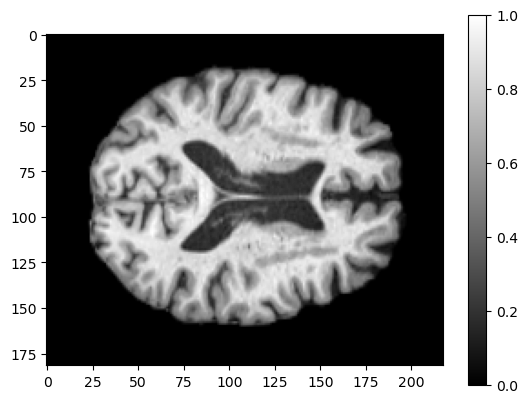

Label: 0, shape: torch.Size([229])


In [13]:
# Visualize data set and print dimensions
test_features, sex_label, age_label, AD_label = next(iter(test_data))
print(test_features.shape)
#print(test_features[6, 0, 20:40, 20:40])
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {AD_label.size()}")
img = test_features[0].squeeze()
print(np.unique(AD_label, return_counts=True))
print(type(img))
print(torch.max(test_features[0,:,:,:]))
label = AD_label[0]
plt.imshow(img[:,:], cmap="gray")
plt.colorbar()
plt.show()
print(f"Label: {label}, shape: {sex_label.shape}")


# Training and Testing

In [11]:
def train(data, enc, dec, optimizer, 
          label_mask={}, label_fraction=0.001, beta_elbo=1.0, alpha_elbo=0.1, batch_size=64, device='cuda:0'):
    epoch_elbo = 0.0
    epoch_correct = 0
    enc.train()
    dec.train()
    age_values = []
    AD_values = []
    N = 0
    # b = batch index
    for b, (images, sex_labels, age_labels, AD_labels) in enumerate(data):
        if images.size()[0] == batch_size:
            N += batch_size

            # AD onehot
            AD_labels_onehot = torch.zeros(batch_size, NUM_AD_GROUP)
            AD_labels_onehot.scatter_(1, AD_labels.unsqueeze(1), 1)
            AD_labels_onehot = torch.clamp(AD_labels_onehot, EPS, 1-EPS)
            
            # Sex onehot
            sex_labels_onehot = torch.zeros(batch_size, NUM_SEX)
            sex_labels_onehot.scatter_(1, sex_labels.unsqueeze(1), 1)
            sex_labels_onehot = torch.clamp(sex_labels_onehot, EPS, 1-EPS)
            
            # Age onehot
            age_labels_onehot = torch.zeros(batch_size, NUM_AGE)
            age_labels_onehot.scatter_(1, age_labels.unsqueeze(1), 1)
            age_labels_onehot = torch.clamp(age_labels_onehot, EPS, 1-EPS)
            
            if CUDA:
                images = images.cuda()
                AD_labels_onehot = AD_labels_onehot.cuda()
                age_labels_onehot = age_labels_onehot.cuda()
                sex_labels_onehot = sex_labels_onehot.cuda()
            optimizer.zero_grad()
            if b not in label_mask: # option to hand over (manual) training mask, if not generated randomly according to LABEL_FRACTION
                label_mask[b] = (random.random() < label_fraction)
            # use label if label_mask is TRUE -> concrete() in enc() uses label 
            if label_mask[b]:
                q = enc(images, labels_AD=AD_labels_onehot, labels_sex=sex_labels_onehot, labels_age=age_labels_onehot, num_samples=NUM_SAMPLES)
            # otherwise, concrete() samples 
            else:
                q = enc(images, labels_AD=None, labels_sex=sex_labels_onehot, labels_age=age_labels_onehot, num_samples=NUM_SAMPLES)
            p = dec(images, q, num_samples=NUM_SAMPLES, N=N)
            loss = -elbo(q, p, beta=beta_elbo, alpha=alpha_elbo)
            loss.backward() # ?
            optimizer.step()
            if CUDA:
                loss = loss.cpu()
            epoch_elbo -= loss.item()
            
            # Training accuracy
            _, y_pred = q['AD_group'].value.max(-1)
            if CUDA:
                y_pred = y_pred.cpu()
            epoch_correct += (AD_labels == y_pred).sum().item() / (NUM_SAMPLES or 1.0)
            
            # Correlatio between age, AD
            _, age_pred = q['age'].value.max(-1)
            _, y_pred = q['AD_group'].value.max(-1)
            age_values.extend(age_pred.tolist())
            AD_values.extend(y_pred.tolist()) 
    
    corr_age_AD = np.corrcoef(np.array(age_values), np.array(AD_values))[0,1]
    return epoch_elbo / N, label_mask, epoch_correct / N, corr_age_AD

def test(data, enc, dec, beta_elbo=1.0, infer=True, alpha_elbo=0.1, batch_size=64):
    enc.eval()
    dec.eval()
    epoch_elbo = 0.0
    epoch_correct = 0
    age_values = []
    AD_values = []
    N = 0
    for b, (images, sex_labels, age_labels, AD_labels) in enumerate(data):
        if images.size()[0] == batch_size:
            N += batch_size

            if CUDA:
                images = images.cuda()
            q = enc(images, num_samples=NUM_SAMPLES)
            p = dec(images, q, num_samples=NUM_SAMPLES)
            batch_elbo = elbo(q, p, beta=beta_elbo, alpha=alpha_elbo)
            if CUDA:
                batch_elbo = batch_elbo.cpu()
            epoch_elbo += batch_elbo.item()
            if infer:
                log_p = p.log_joint(0, 1)
                log_q = q.log_joint(0, 1)
                log_w = log_p - log_q
                w = torch.nn.functional.softmax(log_w, 0)
                y_samples = q['digits'].value
                y_expect = (w.unsqueeze(-1) * y_samples).sum(0)
                _ , y_pred = y_expect.max(-1)
                if CUDA:
                    y_pred = y_pred.cpu()
                epoch_correct += (labels == y_pred).sum().item()
            else:
                _, y_pred = q['AD_group'].value.max(-1)
                if CUDA:
                    y_pred = y_pred.cpu()
                epoch_correct += (AD_labels == y_pred).sum().item() / (NUM_SAMPLES or 1.0)
                
            # Correlatio between age, AD
            _, age_pred = q['age'].value.max(-1)
            _, y_pred = q['AD_group'].value.max(-1)
            age_values.extend(age_pred.tolist())
            AD_values.extend(y_pred.tolist()) 
    
    corr_age_AD = np.corrcoef(np.array(age_values), np.array(AD_values))[0,1]
    return epoch_elbo / N, epoch_correct / N, corr_age_AD

In [12]:
# Define function to plot loss, accuracy
def plot_loss_acc(epochs, train_loss, test_loss, train_accuracy, test_accuracy, train_corr, test_corr, num_cont, learning_rate, beta, alpha, labelfr, data_type="ADNI"):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(10, 5))
    
    ax1.plot(epochs, train_loss, label='train loss')
    ax1.plot(epochs, test_loss, label='test loss')
    ax2.plot(epochs, train_accuracy, label='train accuracy')
    ax2.plot(epochs, test_accuracy, label='test accuracy')
    ax3.plot(epochs, train_corr, label='train correlation')
    ax3.plot(epochs, test_corr, label='test correlation')
    
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('ELBO')

    ax2.set_xlabel('epochs')
    ax2.set_ylabel('accuracy')
    
    ax3.set_xlabel('epochs')
    ax3.set_ylabel('correlation age AD')

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.4,
                        hspace=0.4)
    
    ax1.legend()
    ax2.legend()
    ax3.legend()
    
    # Save graph 
    lr_path = f'./Results/{data_type}/SS/{TYPE_ARCHITECTURE}/lr_{learning_rate}/{CLASS_TYPE}'
    if not os.path.isdir(lr_path):
            os.mkdir(lr_path)
    plt.savefig(os.path.join(lr_path, f'loss_acc_type{CLASS_TYPE}_ep{epochs.size}_lr{learning_rate}_style{num_cont}_beta{beta}_alpha{alpha}_labelfr{labelfr}.png'), dpi=500)
    
    return 

#plot_loss_acc(np.arange(0., 50., 1), train_loss, test_loss, accuracy, 0.001)


In [13]:
import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
import matplotlib.pyplot as plt
import time 

# Define function to plot loss, accuracy with 95% CIs
def plot_loss_acc_var(epochs, train_loss, test_loss, 
                      train_accuracy, test_accuracy, 
                      train_corr, test_corr, num_cont, learning_rate, beta, alpha, labelfr, best_run=0, data_type="ADNI"):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(10, 5))
    
    # Mean and std of losses and accuracies
    d = {'epochs': epochs, 'train_loss': train_loss, 'train_accuracy': train_accuracy_list, 'train_corr': train_corr_list,
         'test_loss': test_loss, 'test_accuracy': test_accuracy_list, 'test_corr': test_corr_list}
    df_mean = pd.DataFrame(data=d)
    df_mean = df_mean.query('train_loss > -1000').groupby(['epochs']).mean()

    df_std = pd.DataFrame(data=d)
    df_std = df_std.query('train_loss > -1000').groupby(['epochs']).std()
    df_std.iloc[:,0:6] = df_std.iloc[:,0:6].apply(lambda x: 1.96 *x/np.sqrt(num_runs.size))
    
    epochs = list(set(epochs))
    
    ax1.plot(epochs, df_mean.train_loss, label='train mean', color='indigo')
    ax1.plot(epochs, df_mean.test_loss, label='test mean', color='mediumvioletred')
    ax2.plot(epochs, df_mean.train_accuracy, label='train mean', color='indigo')
    ax2.plot(epochs, df_mean.test_accuracy, label='test mean', color='mediumvioletred')
    ax3.plot(epochs, df_mean.train_corr, label='train mean', color='indigo')
    ax3.plot(epochs, df_mean.test_corr, label='test mean', color='mediumvioletred')
    
    ax2.plot(epochs, train_accuracy[best_run*200:(best_run+1)*200], label='train best', color='indigo', alpha=0.5)
    ax2.plot(epochs, test_accuracy[best_run*200:(best_run+1)*200], label='test best', color='crimson', alpha=0.4)
    #ax3.plot(epochs, train_corr[best_run*200:(best_run+1)*200], label='train best', color='indigo', alpha=0.4)
    #ax3.plot(epochs, test_corr[best_run*200:(best_run+1)*200], label='test best', color='crimson', alpha=0.28)
    
    ax1.fill_between(epochs, (df_mean.train_loss-df_std.train_loss), (df_mean.train_loss+df_std.train_loss),
                     color='indigo', alpha=.1)
    ax1.fill_between(epochs, (df_mean.test_loss-df_std.test_loss), (df_mean.test_loss+df_std.test_loss),
                     color='mediumvioletred', alpha=.1)
    ax2.fill_between(epochs, (df_mean.train_accuracy-df_std.train_accuracy), (df_mean.train_accuracy+df_std.train_accuracy),
                     color='indigo', alpha=.1)
    ax2.fill_between(epochs, (df_mean.test_accuracy-df_std.test_accuracy), (df_mean.test_accuracy+df_std.test_accuracy),
                     color='mediumvioletred', alpha=.1)
    ax3.fill_between(epochs, (df_mean.train_corr-df_std.train_corr), (df_mean.train_corr+df_std.train_corr),
                     color='indigo', alpha=.1)
    ax3.fill_between(epochs, (df_mean.test_corr-df_std.test_corr), (df_mean.test_corr+df_std.test_corr),
                     color='mediumvioletred', alpha=.1)
    
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('ELBO')

    ax2.set_xlabel('epochs')
    ax2.set_ylabel('accuracy')
    
    ax3.set_xlabel('epochs')
    ax3.set_ylabel('correlation age AD')

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.4,
                        hspace=0.4)
    
    ax1.legend(frameon=False)
    ax2.legend(frameon=False)
    ax3.legend(frameon=False)
    
    # Save graph 
    lr_path = f'./Results/{data_type}/SS/{TYPE_ARCHITECTURE}/lr_{learning_rate}/{CLASS_TYPE}'
    if not os.path.isdir(lr_path):
            os.makedirs(lr_path)
    plt.savefig(os.path.join(lr_path, f'loss_acc_type{CLASS_TYPE}_ep{len(epochs)}_lr{learning_rate}_style{num_cont}_beta{beta}_alpha{alpha}_labelfr{labelfr}.png'), dpi=500)
    
    return 


In [14]:
import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
import matplotlib.pyplot as plt
import time 

# Define function to plot loss, accuracy
def plot_label_fr(label_fractions, epochs, train_accuracy, test_accuracy, num_cont, learning_rate, beta, alpha, data_type="ADNI"):
    fig, ax1 = plt.subplots(1, 1,  figsize=(5, 5))
    
    # Mean and std of losses and accuracies
    d = {'label_fractions': label_fractions, 'epochs': epochs, 'train_accuracy': train_accuracy,
         'test_accuracy': test_accuracy}
    
    unique_lf = list(set(label_fractions))
    unique_lf.sort()
    
    df_mean = pd.DataFrame(data=d)
    df_mean = df_mean.query('epochs > 189').groupby(['label_fractions']).mean()
    
    df_std = pd.DataFrame(data=d)
    df_std = df_std.query('epochs > 189').groupby(['label_fractions']).std()
    df_std.iloc[:,1:4] = df_std.iloc[:,1:4].apply(lambda x: 1.96 *x/np.sqrt(num_runs.size))
    
    epochs = list(set(epochs))
    
    ax1.errorbar(unique_lf, df_mean.train_accuracy, df_std.train_accuracy, capsize=3, label='train mean', linestyle='dashed', color='indigo', marker='s')
    ax1.errorbar(unique_lf, df_mean.test_accuracy, df_std.test_accuracy, capsize=3,  label='test mean', linestyle='dashed', color='mediumvioletred', marker='s')
    
    ax1.set_xlabel('label fraction')
    ax1.set_ylabel('last 10 mean accuracy')
    
    ax1.set_xticks(unique_lf)
    
    ax1.legend(frameon=False)
    
    # Save graph 
    lr_path = f'./Results/{data_type}/SS/{TYPE_ARCHITECTURE}/lr_{learning_rate}/{CLASS_TYPE}'
    if not os.path.isdir(lr_path):
            os.makedirs(lr_path)
    plt.savefig(os.path.join(lr_path, f'lf_acc_{CLASS_TYPE}_ep{len(epochs)}_lr{learning_rate}_style{num_cont}_beta{beta}_alpha{alpha}.png'), dpi=500)
    
    return 

In [15]:
def save_to_csv(epochs, train_loss, test_loss, train_accuracy, test_accuracy,  train_corr, test_corr, num_cont, learning_rate, beta, alpha, labelfr, data_type="ADNI"):
    
    epochs_list = ['epochs']
    train_loss_list = ['train_loss']
    test_loss_list = ['test_loss']
    train_acc_list = ['train_accuracy']
    test_acc_list = ['test_accuracy']
    train_corr_list = ['train_corr']
    test_corr_list = ['test_corr']
    
    epochs_list.extend(epochs)
    train_loss_list.extend(train_loss)
    test_loss_list.extend(test_loss)
    train_acc_list.extend(train_accuracy)
    test_acc_list.extend(test_accuracy)
    test_corr_list.extend(test_corr)
    train_corr_list.extend(train_corr)
    
    lr_path = f'./Results/{data_type}/SS/{TYPE_ARCHITECTURE}/lr_{learning_rate}/{CLASS_TYPE}'
    if not os.path.isdir(lr_path):
            os.mkdir(lr_path)
    np.savetxt(os.path.join(lr_path, f'loss_acc_type{CLASS_TYPE}_ep{len(epochs)}_lr{learning_rate}_style{num_cont}_beta{beta}_alpha{alpha}_labelfr{labelfr}.csv'),
               [p for p in zip(epochs_list, train_loss_list, test_loss_list, train_acc_list, test_acc_list)], 
               delimiter=',', fmt='%s')
    
    return

In [27]:
def train_ADNI(config, checkpoint_dir=None):
    
    # Load data
    train_data, val_data, test_data = load_ADNI2D(batch_size =int(config["batch_size"]),
                                                  class_type=CLASS_TYPE, 
                                                  normalized=config["normalized"])
    # Set seeds
    np.random.seed(int(config["seed"]))
    torch.manual_seed(int(config["seed"]))
    
    enc = Encoder(num_cont = int(config["num_cont"]), temperature=config["temperature"])
    dec = Decoder(num_cont = int(config["num_cont"]), temperature=config["temperature"])
        
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            enc = nn.DataParallel(enc)
            dec = nn.DataParallel(dec)
    #enc.to(device)
    #dec.to(device)

    if CUDA:
        enc.cuda()
        dec.cuda()
        cuda_tensors(enc)
        cuda_tensors(dec)
    
    optimizer =  torch.optim.Adam(list(enc.parameters())+list(dec.parameters()),
                                  lr=config["lr"],
                                  betas=(BETA1, 0.999))
    
    for epoch in range(100):  # loop over the dataset multiple times
        
        # Train
        train_start = time.time()
        train_elbo, mask, train_accuracy, train_corr = train(train_data, enc, dec,
                                                 optimizer,
                                                 #device=device,
                                                 label_fraction=config["lf"], 
                                                 beta_elbo=config["beta"], 
                                                 alpha_elbo=config["alpha"],
                                                 batch_size=config["batch_size"])
        train_end = time.time()
        
        # Validation 
        val_start = time.time()
        val_elbo, val_accuracy, test_corr = test(val_data, enc, dec,
                                      #device=device,
                                      beta_elbo=config["beta"],
                                      alpha_elbo=config["alpha"],
                                      batch_size=config["batch_size"],
                                      infer=False)
        val_end = time.time()
        
        #print('[Epoch %d] Train: ELBO %.4e (%ds), Accuracy %0.3f Val: ELBO %.4e, Accuracy %0.3f (%ds)' % (
        #                            epoch, train_elbo, train_end - train_start, train_accuracy,
        #                            val_elbo, val_accuracy, val_end - val_start))
        
        # Uncomment for saving checkpoints, but attention to limited disk space (1 checkpoint ~ 300mb)
        #if (epoch+1) % 100 == 0:
        #    with tune.checkpoint_dir(epoch) as checkpoint_dir:
        #        path_enc = os.path.join(checkpoint_dir, "checkpoint_enc")
        #        path_dec = os.path.join(checkpoint_dir, "checkpoint_dec")
        #        torch.save((enc.state_dict(), optimizer.state_dict()), path_enc)
        #        torch.save((dec.state_dict(), optimizer.state_dict()), path_dec)
                
        tune.report(loss=val_elbo, accuracy=val_accuracy)         
                    
    print("Finished Training")
                
                
                

In [28]:
# Randomized grid search
import time
import random
from functools import partial
import torchvision
from ray import tune
from ray.tune import CLIReporter, JupyterNotebookReporter 
from ray.tune.schedulers import ASHAScheduler

# Training parameters 
num_samples= 400
max_num_epochs = 100
gpus_per_trial = 1

# Define cuda_tensor
def cuda_tensors(obj): 
    for attr in dir(obj):
        value = getattr(obj, attr)
        if isinstance(value, torch.Tensor):
            setattr(obj, attr, value.cuda())

# Hyperparameterspace
config = {
    "num_cont": tune.choice([10, 50, 100]),
    "lf": tune.choice([0]),
    "temperature": tune.choice([0.01, 0.1, 0.3, 0.6, 1]),
    "lr": tune.choice([1e-3, 1e-4, 1e-5, 1e-6]),
    "alpha": tune.choice([20, 50, 100, 200, 500]),
    "beta": tune.choice([0.1, 1, 4, 10, 100]),
    "seed": tune.choice([11, 4, 27, 2]),
    "normalized": tune.choice([True, False]),
    "batch_size": tune.choice([16, 32, 64])
}

# Set metric (for discussion on other variables see https://discuss.ray.io/t/when-to-use-asha/458/3)
scheduler = ASHAScheduler(
        metric="accuracy", #loss defined in training function
        mode="max",
        max_t=max_num_epochs,
        grace_period=10, # iterations after which ASHA terminates if metric doesn't improve
        reduction_factor=10) # iterations after which ASHA reevaluates metric and determine to stop a trial

reporter = JupyterNotebookReporter(
    parameter_columns= ["num_cont", "lr", "lf", "alpha", "beta", "seed", "normalized", "batch_size", "temperature"],
    metric_columns=["loss", "accuracy", "training_iteration"])

result = tune.run(
        partial(train_ADNI, checkpoint_dir="./tune_checkpoints/"),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)
        #local_dir='C:\\Users\\jojoa\\OneDrive\\Dokumente\\Master Statistik\\Masterarbeit\\Programming\\')

best_trial = result.get_best_trial("accuracy", "max", "last")
print("Best trial id: {}".format(best_trial.trial_id))
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))


best_enc = Encoder(num_cont = int(best_trial.config["num_cont"]), temperature=best_trial.config["temperature"])
best_dec = Decoder(num_cont = int(best_trial.config["num_cont"]), temperature=best_trial.config["temperature"])

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if gpus_per_trial > 1:
        best_enc = nn.DataParallel(best_enc)
        best_dec = nn.DataParallel(best_dec)
#        best_enc.to(device)
#        best_dec.to(device)

if CUDA:
    best_enc.cuda()
    best_dec.cuda()
    cuda_tensors(best_enc)
    cuda_tensors(best_dec)

best_checkpoint_dir = best_trial.checkpoint.dir_or_data
best_enc_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, "checkpoint_enc"))
best_dec_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, "checkpoint_dec"))
best_enc.load_state_dict(best_enc_state)
best_dec.load_state_dict(best_dec_state)

# Load test data
_, _, test_data = load_ADNI2D(batch_size =int(best_trial.config["batch_size"]),
                              class_type=CLASS_TYPE, 
                              normalized=best_trial.config["normalized"], 
                              seed=int(best_trial.config["seed"]))

_, test_acc, _ = test(test_data, best_enc, best_dec, beta_elbo=best_trial.config["beta"],
                                      alpha_elbo=best_trial.config["alpha"],
                                      batch_size=best_trial.config["batch_size"],
                                      infer=False)
print("Best trial test set accuracy: {}".format(test_acc))

2023-04-24 20:42:47,678	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
/home/johannes/anaconda3/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py:610: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/master/tune/api_docs/trainable.html

  warnings.warn(
2023-04-24 20:42:49,388	INFO tensorboardx.py:170 -- pip install "ray[tune]" to see TensorBoard files.
2023-04-24 20:42:49,389	WARNING callback.py:108 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboard

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_ADNI_cffc3_00000,0.401786,2023-04-24_20-45-32,True,,5906fcad1e4b40cc8feaa7ef76f55191,cuda02,100,-399.123,172.29.16.3,3869654,153.781,1.3988,153.781,1682361932,0,,100,cffc3_00000,0.00562143
train_ADNI_cffc3_00001,0.28125,2023-04-24_20-46-05,True,,3f7135b43f75408e8e21dbed9e8bc693,cuda02,10,-381.425,172.29.16.3,3878256,23.9603,1.41976,23.9603,1682361965,0,,10,cffc3_00001,0.00538373


2023-04-24 20:46:18,182	WARNING tune.py:690 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2023-04-24 20:46:24,940	ERROR tune.py:758 -- Trials did not complete: [train_ADNI_cffc3_00002, train_ADNI_cffc3_00003, train_ADNI_cffc3_00004, train_ADNI_cffc3_00005, train_ADNI_cffc3_00006, train_ADNI_cffc3_00007, train_ADNI_cffc3_00008, train_ADNI_cffc3_00009, train_ADNI_cffc3_00010, train_ADNI_cffc3_00011, train_ADNI_cffc3_00012, train_ADNI_cffc3_00013, train_ADNI_cffc3_00014, train_ADNI_cffc3_00015, train_ADNI_cffc3_00016, train_ADNI_cffc3_00017, train_ADNI_cffc3_00018, train_ADNI_cffc3_00019, train_ADNI_cffc3_00020, train_ADNI_cffc3_00021, train_ADNI_cffc3_00022, train_ADNI_cffc3_00023, train_ADNI_cffc3_00024, train_ADNI_cffc3_00025, train_ADNI_cffc3_00026, train_ADNI_cffc3_00027, train_ADNI_cffc3_00028, train_ADNI_cffc3_00029, train_ADNI_cffc3_00030

Best trial id: cffc3_00000
Best trial config: {'num_cont': 10, 'lf': 0, 'temperature': 1, 'lr': 1e-06, 'alpha': 50, 'beta': 0.1, 'seed': 2, 'normalized': True, 'batch_size': 32}
Best trial final validation loss: -399.1233476911272
Best trial final validation accuracy: 0.4017857142857143


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [16]:
import time
import random

# Epoch range for plotting 
epochs = np.arange(0., 200, 1)
num_runs = np.arange(0, 1, 1)

# Hyperparameters - best accuracy
num_conts = np.array([10])
label_fractions = np.array([0.5])
learning_rates = np.array([1e-3])
alphas = np.array([50])
betas = np.array([1])
temps = np.array([0.1])
normalized = True
batch_size = 16
seed = 27

# Define cuda_tensor
def cuda_tensors(obj): 
    for attr in dir(obj):
        value = getattr(obj, attr)
        if isinstance(value, torch.Tensor):
            setattr(obj, attr, value.cuda())
        
# Load dataloaders
train_data, _, test_data = load_ADNI2D(batch_size = batch_size, class_type=CLASS_TYPE, normalized=normalized)

# Initialize lists for plotting 
initialize_lists = True
if initialize_lists:
    label_fraction_list = []
    train_loss = []
    train_accuracy_list = []
    train_corr_list = []
    test_loss = []
    test_accuracy_list = []
    test_corr_list = []

for label_fraction in label_fractions:

    for num_cont in num_conts:

        for run in num_runs:

            for lr in learning_rates:

                for alpha in alphas:

                    for beta in betas:

                        for temp in temps:
                            
                            print(f'Start run {run}')
                            print(f'Start learning with num cont {num_cont}')
                            print(f'Start learning with label fraction {label_fraction}')
                            print(f'Start learning with learning rate {lr}')
                            print(f'Start learning with alpha {alpha}')
                            print(f'Start learning with beta {beta}')
                            print(f'Start learning with temp {temp}')
                            
                            # Set seeds
                            #np.random.seed(int(seed))
                            #torch.manual_seed(int(seed))

                            enc = Encoder(num_cont = num_cont, temperature = temp)
                            dec = Decoder(num_cont = num_cont, temperature = temp)
                            if CUDA:
                                enc.cuda()
                                dec.cuda()
                                cuda_tensors(enc)
                                cuda_tensors(dec)

                            optimizer =  torch.optim.Adam(list(enc.parameters())+list(dec.parameters()),
                                                          lr=lr,
                                                          betas=(BETA1, 0.999))

                            if not RESTORE:
                                mask = {}
                                for e in epochs:

                                    # Train
                                    train_start = time.time()
                                    train_elbo, mask, train_accuracy, train_corr = train(train_data, enc, dec, 
                                                                                         optimizer, mask, 
                                                                                         label_fraction, 
                                                                                         beta_elbo=beta, alpha_elbo=alpha,
                                                                                         batch_size=batch_size)
                                    train_end = time.time()
                                    test_start = time.time()

                                    # Test
                                    test_elbo, test_accuracy, test_corr = test(test_data, enc, dec, 
                                                                               beta_elbo=beta, alpha_elbo=alpha, 
                                                                               batch_size=batch_size,
                                                                               infer=False)
                                    test_end = time.time()
                                    print('[Epoch %d] Train: ELBO %.4e (%ds), Accuracy %0.3f Test: ELBO %.4e, Accuracy %0.3f (%ds)' % (
                                            e, train_elbo, train_end - train_start, train_accuracy,
                                            test_elbo, test_accuracy, test_end - test_start))

                                    # Save metrics
                                    label_fraction_list.append(label_fraction)
                                    train_loss.append(train_elbo)
                                    train_corr_list.append(train_corr)
                                    test_loss.append(test_elbo)
                                    test_accuracy_list.append(test_accuracy)
                                    train_accuracy_list.append(train_accuracy)
                                    test_corr_list.append(test_corr)

                                #plot_loss_acc(epochs, train_loss, test_loss, 
                                #              train_accuracy_list, test_accuracy_list, 
                                #              train_corr_list, test_corr_list,
                                #              num_cont, lr, beta, alpha, label_fraction)
                                #save_to_csv(epochs, train_loss, test_loss,
                                #            train_accuracy_list, test_accuracy_list, 
                                #            train_corr_list, test_corr_list,
                                #            num_cont, lr, beta, alpha, label_fraction)

                                if not os.path.isdir(WEIGHTS_PATH):
                                    os.mkdir(WEIGHTS_PATH)
                                torch.save(enc.state_dict(),
                                           '%s/%s-styledim%s-lr%s-beta%s-alpha%s-labelfr%s-enc.rar' % (WEIGHTS_PATH, MODEL_NAME, num_cont, lr, beta, alpha, label_fraction))
                                torch.save(dec.state_dict(),
                                           '%s/%s-styledim%s-lr%s-beta%s-alpha%s-labelfr%s-dec.rar' % (WEIGHTS_PATH, MODEL_NAME, num_cont, lr, beta, alpha, label_fraction))

Start run 0
Start learning with num cont 10
Start learning with label fraction 0.5
Start learning with learning rate 0.001
Start learning with alpha 50
Start learning with beta 1
Start learning with temp 0.1
[Epoch 0] Train: ELBO -9.1580e+02 (5s), Accuracy 0.674 Test: ELBO -7.7635e+02, Accuracy 0.362 (0s)
[Epoch 1] Train: ELBO -7.7707e+02 (1s), Accuracy 0.682 Test: ELBO -7.6227e+02, Accuracy 0.357 (0s)
[Epoch 2] Train: ELBO -7.6991e+02 (1s), Accuracy 0.658 Test: ELBO -7.6065e+02, Accuracy 0.348 (0s)
[Epoch 3] Train: ELBO -7.6622e+02 (1s), Accuracy 0.667 Test: ELBO -7.5949e+02, Accuracy 0.371 (0s)
[Epoch 4] Train: ELBO -7.6400e+02 (1s), Accuracy 0.677 Test: ELBO -7.5716e+02, Accuracy 0.357 (0s)
[Epoch 5] Train: ELBO -7.6190e+02 (1s), Accuracy 0.667 Test: ELBO -7.6652e+02, Accuracy 0.348 (0s)
[Epoch 6] Train: ELBO -7.6237e+02 (2s), Accuracy 0.659 Test: ELBO -7.4814e+02, Accuracy 0.478 (0s)
[Epoch 7] Train: ELBO -7.5623e+02 (1s), Accuracy 0.670 Test: ELBO -7.4610e+02, Accuracy 0.411 (0s)


[Epoch 80] Train: ELBO -6.9168e+02 (1s), Accuracy 0.988 Test: ELBO -7.5169e+02, Accuracy 0.545 (0s)
[Epoch 81] Train: ELBO -6.9181e+02 (1s), Accuracy 0.981 Test: ELBO -7.5088e+02, Accuracy 0.527 (0s)
[Epoch 82] Train: ELBO -6.9164e+02 (1s), Accuracy 0.979 Test: ELBO -7.5246e+02, Accuracy 0.496 (0s)
[Epoch 83] Train: ELBO -6.9088e+02 (1s), Accuracy 0.987 Test: ELBO -7.5107e+02, Accuracy 0.464 (0s)
[Epoch 84] Train: ELBO -6.9046e+02 (1s), Accuracy 0.981 Test: ELBO -7.5247e+02, Accuracy 0.531 (0s)
[Epoch 85] Train: ELBO -6.9023e+02 (1s), Accuracy 0.990 Test: ELBO -7.5450e+02, Accuracy 0.438 (0s)
[Epoch 86] Train: ELBO -6.9015e+02 (2s), Accuracy 0.982 Test: ELBO -7.5369e+02, Accuracy 0.442 (0s)
[Epoch 87] Train: ELBO -6.9153e+02 (1s), Accuracy 0.936 Test: ELBO -7.5506e+02, Accuracy 0.496 (0s)
[Epoch 88] Train: ELBO -6.9092e+02 (1s), Accuracy 0.990 Test: ELBO -7.5420e+02, Accuracy 0.500 (0s)
[Epoch 89] Train: ELBO -6.9062e+02 (1s), Accuracy 0.964 Test: ELBO -7.5168e+02, Accuracy 0.487 (0s)


[Epoch 162] Train: ELBO -6.8249e+02 (1s), Accuracy 1.000 Test: ELBO -7.5620e+02, Accuracy 0.464 (0s)
[Epoch 163] Train: ELBO -6.8171e+02 (2s), Accuracy 0.999 Test: ELBO -7.5804e+02, Accuracy 0.518 (0s)
[Epoch 164] Train: ELBO -6.8155e+02 (1s), Accuracy 0.999 Test: ELBO -7.5714e+02, Accuracy 0.527 (0s)
[Epoch 165] Train: ELBO -6.8299e+02 (1s), Accuracy 0.981 Test: ELBO -7.5743e+02, Accuracy 0.513 (0s)
[Epoch 166] Train: ELBO -6.8361e+02 (1s), Accuracy 0.990 Test: ELBO -7.5689e+02, Accuracy 0.545 (0s)
[Epoch 167] Train: ELBO -6.8269e+02 (1s), Accuracy 0.999 Test: ELBO -7.5853e+02, Accuracy 0.540 (0s)
[Epoch 168] Train: ELBO -6.8276e+02 (1s), Accuracy 0.990 Test: ELBO -7.5634e+02, Accuracy 0.513 (0s)
[Epoch 169] Train: ELBO -6.8241e+02 (1s), Accuracy 0.988 Test: ELBO -7.5699e+02, Accuracy 0.446 (0s)
[Epoch 170] Train: ELBO -6.8234e+02 (2s), Accuracy 0.993 Test: ELBO -7.5753e+02, Accuracy 0.531 (0s)
[Epoch 171] Train: ELBO -6.8177e+02 (2s), Accuracy 0.993 Test: ELBO -7.5747e+02, Accuracy 0

ValueError: Expected parameter logits (Tensor of shape (16, 2)) of distribution Categorical(logits: torch.Size([16, 2])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]], device='cuda:0', grad_fn=<SubBackward0>)

In [39]:
# run collapsed, delete n last entries of lists -> rerun above with initilize_lists = false
n=151
del label_fraction_list[-n:]
del train_loss[-n:]
del train_accuracy_list[-n:]
del train_corr_list[-n:]
del test_loss[-n:]
del test_accuracy_list[-n:]
del test_corr_list[-n:]

In [42]:
# Check length 
print(len(label_fraction_list))
print(len(train_loss))
print(len(test_loss))
print(len(train_accuracy_list))
print(len(test_accuracy_list))
print(len(test_corr_list))
len(train_corr_list)

5000
5000
5000
5000
5000
5000


1326

In [94]:
# possible save lists in case CUDA runs out of memory 
import pickle
with open("label_fraction_list", "wb") as fp:   #Pickling
    pickle.dump(label_fraction_list, fp)
with open("train_loss", "wb") as fp:   #Pickling
    pickle.dump(train_loss, fp)
with open("train_accuracy_list", "wb") as fp:   #Pickling
    pickle.dump(train_accuracy_list, fp)
with open("test_loss", "wb") as fp:   #Pickling
    pickle.dump(test_loss, fp)
with open("test_accuracy_list", "wb") as fp:   #Pickling
    pickle.dump(test_accuracy_list, fp)
with open("test_corr_list", "wb") as fp:   #Pickling
    pickle.dump(test_corr_list, fp)

In [15]:
import pickle
with open("label_fraction_list", "rb") as fp:   #Pickling
    label_fraction_list = pickle.load(fp)
with open("train_loss", "rb") as fp:   #Pickling
    train_loss = pickle.load(fp)
with open("train_accuracy_list", "rb") as fp:   #Pickling
    train_accuracy_list = pickle.load(fp)
with open("test_loss", "rb") as fp:   #Pickling
    test_loss = pickle.load(fp)
with open("test_accuracy_list", "rb") as fp:   #Pickling
    test_accuracy_list = pickle.load(fp)
with open("test_corr_list", "rb") as fp:   #Pickling
    test_corr_list = pickle.load(fp)

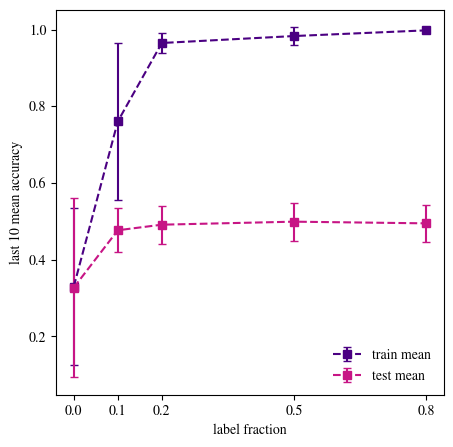

In [43]:
# Plot label fraction graph (only with enough entries in lists)
import itertools
import pandas as pd
eps = [e for e in itertools.repeat(epochs.tolist(), 10*5)]
eps = [item for sublist in eps for item in sublist]

plot_label_fr(label_fraction_list, eps[:len(label_fraction_list)], train_accuracy_list, test_accuracy_list,
                  num_cont, lr, beta, alpha)

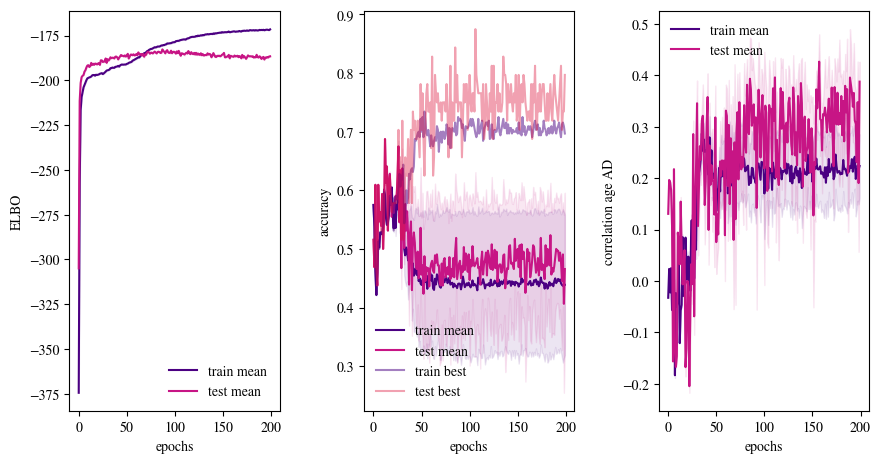

In [24]:
# Plot metrics
import itertools
import pandas as pd
eps = [e for e in itertools.repeat(epochs.tolist(), num_runs.size)]
eps = [item for sublist in eps for item in sublist]
save_to_csv(eps, train_loss, test_loss,
            train_accuracy_list, test_accuracy_list, 
            train_corr_list, test_corr_list,
            num_cont, lr, beta, alpha, label_fraction)
plot_loss_acc_var(eps, train_loss, test_loss, train_accuracy_list, test_accuracy_list,
                  train_corr_list, test_corr_list,
                  num_cont, lr, beta, alpha, label_fraction, best_run=9)

# Reconstruction patterns

In [46]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
import time 

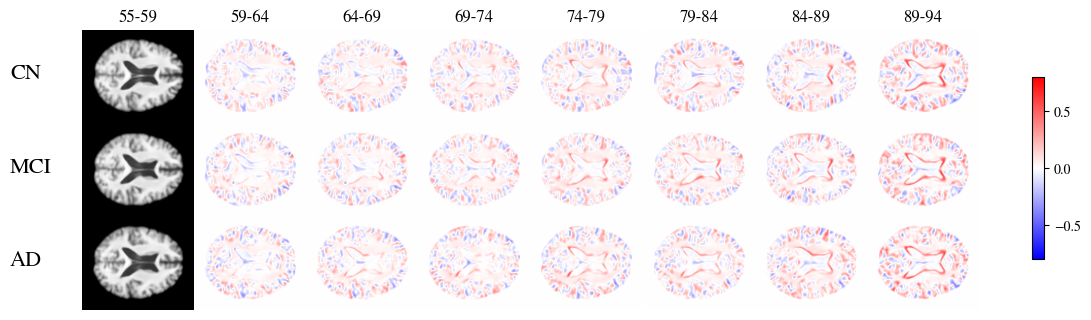

In [25]:
# Compare AD age reconstruction differences
if CLASS_TYPE == 'EMCI_LMCI':
    AD_labels_map = {
        0: "CN",
        1: "EMCI",
        2: "LMCI",
        3: "AD"}
    
    cbar_w = 0.009
    cbar_h = 0.5
    cbar_b = 0.25
    cbar_range = 0.6
    fig_height = 4.4
    fig_width = 12.6
    #fig_height = 4.3
    #fig_width = 13.9
elif CLASS_TYPE == 'CN_AD':
    AD_labels_map = {
        0: "CN",
        1: "AD"}
    
    cbar_w = 0.01
    cbar_h = 0.6
    cbar_b = 0.2
    cbar_range = 0.4
    fig_height = 2.7
    fig_width = 15.2
elif CLASS_TYPE == 'CN_MCI_AD':
    AD_labels_map = {
        0: "CN",
        1: "MCI",
        2: "AD"}
    
    cbar_w = 0.009
    cbar_h = 0.5
    cbar_b = 0.25
    cbar_range = 0.8
    fig_height = 3.64
    fig_width = 13.3
sex_labels_map = {
    0: "M",
    1: "F"}
age_labels_map = {
    0: "55-59",
    1: "59-64",
    2: "64-69",
    3: "69-74",
    4: "74-79",
    5: "79-84",
    6: "84-89",
    7: "89-94"}

# Set figure parameters
fig, ax = plt.subplots(nrows=NUM_AD_GROUP, ncols=NUM_AGE, figsize=(fig_width, fig_height))

# Null image for decoder 
null_image = torch.tensor(np.zeros((182, 218)))
    
# Zero cont dimensions 
z0 = torch.tensor(np.zeros((1,num_conts[0]), 'f'))
    
sex_hot = np.zeros((1,NUM_SEX), 'f')
sex_hot = torch.tensor(sex_hot)

baseline_images = []

for age in range(NUM_AGE):
    
    age_hot = np.zeros((1,NUM_AGE), 'f')
    age_hot[0, age] = 1
    age_hot = torch.tensor(age_hot)
        
    for ad in range(NUM_AD_GROUP):
        
        AD_hot = np.zeros((1,NUM_AD_GROUP), 'f')
        AD_hot[0, ad] = 1
        AD_hot = torch.tensor(AD_hot)
        
        if age == 0:
            # Generate first image
            p = dec(null_image.cuda(), {'cont': z0.cuda(),
                                        'sex': sex_hot.cuda(),
                                        'age': age_hot.cuda(),
                                        'AD_group': AD_hot.cuda()})
            images = p['images'].value.data.cpu().numpy()
            
            slice_recon = images.reshape(182, 218)
            
            baseline_images.append(slice_recon)
      
            ax[ad, age].imshow(slice_recon, cmap='gray') #, vmin=0, vmax=1000)
        else:
            p = dec(null_image.cuda(), {'cont': z0.cuda(),
                                        'sex': sex_hot.cuda(),
                                        'age': age_hot.cuda(),
                                        'AD_group': AD_hot.cuda()})
            images = p['images'].value.data.cpu().numpy()
    
            slice_recon = images.reshape(182, 218)
            
            diff_image = baseline_images[ad] - slice_recon
            
            #ax = plt.subplot(gs1[ad, age])
            im = ax[ad, age].imshow(diff_image, cmap='bwr', vmin=-cbar_range, vmax=cbar_range)        
        
        if ad == 0: ax[ad, age].set_title(f'{age_labels_map[age]}')
        ax[ad, age].tick_params(bottom= False, left=False, labelbottom=False, labelleft=False)
        if age == 0: ax[ad, age].text(-140, 95, f'{AD_labels_map[ad]}', size=16)
        
        ax[ad, age].set_axis_off()

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, cbar_b, cbar_w, cbar_h])
fig.colorbar(im, cax=cbar_ax)
path = f'./Results/ADNI/SS/{TYPE_ARCHITECTURE}/images/{CLASS_TYPE}'
if not os.path.isdir(path):
    os.makedirs(path)
fig.savefig(os.path.join(path, f'age_variation_type_lf{label_fractions[0]}_{CLASS_TYPE}.png'), dpi=600)

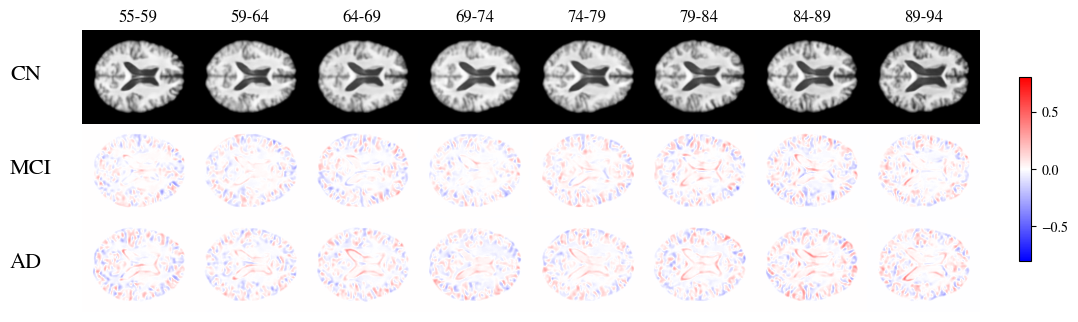

In [26]:
# Compare AD age reconstruction differences
if CLASS_TYPE == 'EMCI_LMCI':
    AD_labels_map = {
        0: "CN",
        1: "EMCI",
        2: "LMCI",
        3: "AD"}
    
    cbar_w = 0.009
    cbar_h = 0.5
    cbar_b = 0.25
    cbar_range = 0.5
    fig_height = 4.6
    fig_width = 12.5
elif CLASS_TYPE == 'CN_AD':
    AD_labels_map = {
        0: "CN",
        1: "AD"}
    
    cbar_w = 0.01
    cbar_h = 0.6
    cbar_b = 0.2
    cbar_range = 0.3
    fig_height = 2.8
    fig_width = 14.8
elif CLASS_TYPE == 'CN_MCI_AD':
    AD_labels_map = {
        0: "CN",
        1: "MCI",
        2: "AD"}
    cbar_w = 0.009
    cbar_h = 0.5
    cbar_b = 0.25
    cbar_range = 0.8
    fig_height = 3.67
    fig_width = 13.3
sex_labels_map = {
    0: "M",
    1: "F"}
age_labels_map = {
    0: "55-59",
    1: "59-64",
    2: "64-69",
    3: "69-74",
    4: "74-79",
    5: "79-84",
    6: "84-89",
    7: "89-94"}

# Set figure parameters
fig, ax = plt.subplots(nrows=NUM_AD_GROUP, ncols=NUM_AGE, figsize=(fig_width, fig_height))

# Null image for decoder 
null_image = torch.tensor(np.zeros((182, 218)))
    
# Zero cont dimensions 
z0 = torch.tensor(np.zeros((1,num_conts[0]), 'f'))
    
sex_hot = np.zeros((1,NUM_SEX), 'f')
sex_hot = torch.tensor(sex_hot)

baseline_images = []

for age in range(NUM_AGE):
    
    age_hot = np.zeros((1,NUM_AGE), 'f')
    age_hot[0, age] = 1
    age_hot = torch.tensor(age_hot)
        
    for ad in range(NUM_AD_GROUP):
        
        AD_hot = np.zeros((1,NUM_AD_GROUP), 'f')
        AD_hot[0, ad] = 1
        AD_hot = torch.tensor(AD_hot)
        
        if ad == 0:
            # Generate first image
            p = dec(null_image.cuda(), {'cont': z0.cuda(),
                                        'sex': sex_hot.cuda(),
                                        'age': age_hot.cuda(),
                                        'AD_group': AD_hot.cuda()})
            images = p['images'].value.data.cpu().numpy()
            
            slice_recon = images.reshape(182, 218)
            
            baseline_images.append(slice_recon)
        
            ax[ad, age].imshow(slice_recon, cmap='gray') #, vmin=0, vmax=1000)
        else:
            p = dec(null_image.cuda(), {'cont': z0.cuda(),
                                        'sex': sex_hot.cuda(),
                                        'age': age_hot.cuda(),
                                        'AD_group': AD_hot.cuda()})
            images = p['images'].value.data.cpu().numpy()
    
            slice_recon = images.reshape(182, 218)
            
            diff_image = baseline_images[age] - slice_recon
            
            im = ax[ad, age].imshow(diff_image, cmap='bwr', vmin=-cbar_range, vmax=cbar_range)        
        
        if ad == 0: ax[ad, age].set_title(f'{age_labels_map[age]}')
        ax[ad, age].tick_params(bottom= False, left=False, labelbottom=False, labelleft=False)
        if age == 0: ax[ad, age].text(-140, 95, f'{AD_labels_map[ad]}', size=16)
        
        ax[ad, age].set_axis_off()

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, cbar_b, cbar_w, cbar_h])
fig.colorbar(im, cax=cbar_ax)

path = f'./Results/ADNI/SS/{TYPE_ARCHITECTURE}/images/{CLASS_TYPE}'
if not os.path.isdir(path):
    os.makedirs(path)
fig.savefig(os.path.join(path, f'AD_variation_type_lf{label_fractions[0]}_{CLASS_TYPE}.png'), dpi=600)